# Определение температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Предстоит построить модель, которая предскажет температуру стали.


**Описание этапа обработки**


Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).


Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.


Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Цель проекта:** Обучить модель прогнозировать температуру стали.

**Целевая метрика:** MAE (<=6.8)



## Общая информация

In [1]:
# библиотеки
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import time

In [2]:
# функция для загрузки данных
def load_data(path_1, path_2):

    if not os.path.exists('datasets'):
        os.makedirs('datasets')

    local_path = os.path.join('datasets', path_1)
    if os.path.exists(local_path):
        df = pd.read_csv(local_path)
        print('Файл загружен локально')
    else:
        try:
            df = pd.read_csv(path_2)
            print('Файл загружен из сети')
        except:
            print('Не удалось загрузить файл')
    return df

In [3]:
# загрузка данных
data_arc = load_data('data_arc_new.csv', 
                     'https://datasets/data_arc_new.csv')

data_bulk = load_data('data_bulk_new.csv', 
                     'https://datasets/data_bulk_new.csv')

data_bulk_time = load_data('data_bulk_time_new.csv', 
                     'https://datasets/data_bulk_time_new.csv')

data_gas = load_data('data_gas_new.csv', 
                     'https://datasets/data_gas_new.csv')

data_temp = load_data('data_temp_new.csv', 
                     'https://datasets/data_temp_new.csv')

data_wire = load_data('data_wire_new.csv', 
                     'https://datasets/data_wire_new.csv')

data_wire_time = load_data('data_wire_time_new.csv', 
                     'https://datasets/data_wire_time_new.csv')

Файл загружен из сети
Файл загружен из сети
Файл загружен из сети
Файл загружен из сети
Файл загружен из сети
Файл загружен из сети
Файл загружен из сети


## Исследовательский анализ данных

### Электроды

In [4]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


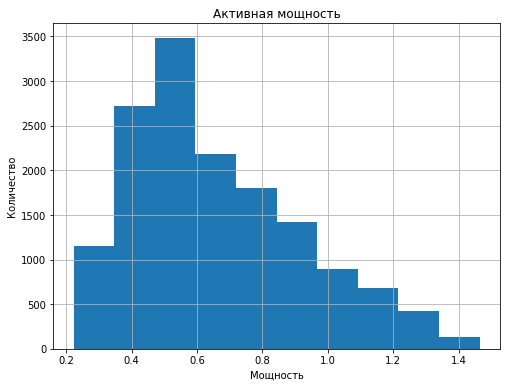

In [7]:
data_arc['Активная мощность'].hist(figsize=(8, 6))
plt.title('Активная мощность')
plt.xlabel('Мощность')
plt.ylabel('Количество');

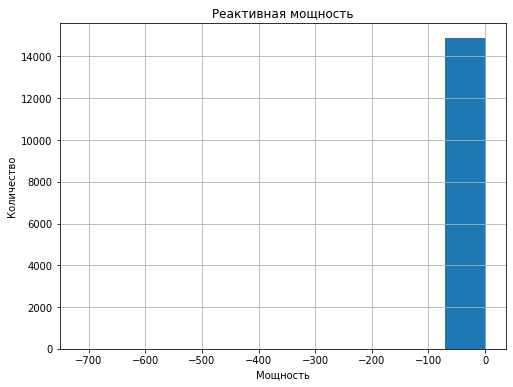

In [8]:
data_arc['Реактивная мощность'].hist(figsize=(8, 6))
plt.title('Реактивная мощность')
plt.xlabel('Мощность')
plt.ylabel('Количество');

In [9]:
data_arc[data_arc['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


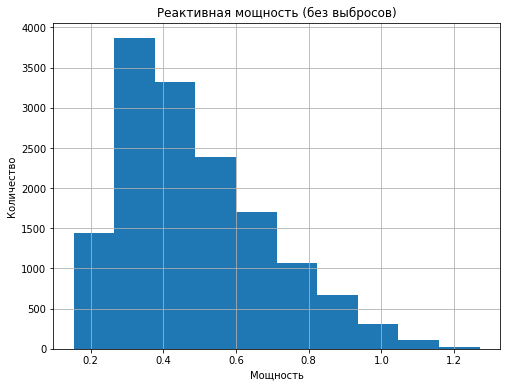

In [10]:
(data_arc[data_arc['Реактивная мощность']>0]['Реактивная мощность']
 .hist(figsize=(8, 6)))
plt.title('Реактивная мощность (без выбросов)')
plt.xlabel('Мощность')
plt.ylabel('Количество');

В данных об элеткродах нет пропусков, но есть повторящиеся ключи. 

Есть аномальное значение реактивной мощности. В жизни такое может быть, но в данном случае мы имеет единичную запись, что можно списать на ошибку при замерах. Без этой аномалии у реактивной мощности данные имеют нормальное распределение с уклоном влево. Такое же распределение и у активной мощности.

Также для обучения модели можно вычислить полную мощность и именно ее использовать как признак. 

Из инфорамции о данных и времени можно вытянуть общее время нагрева.

### Подача сыпучих материалов

In [11]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [12]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


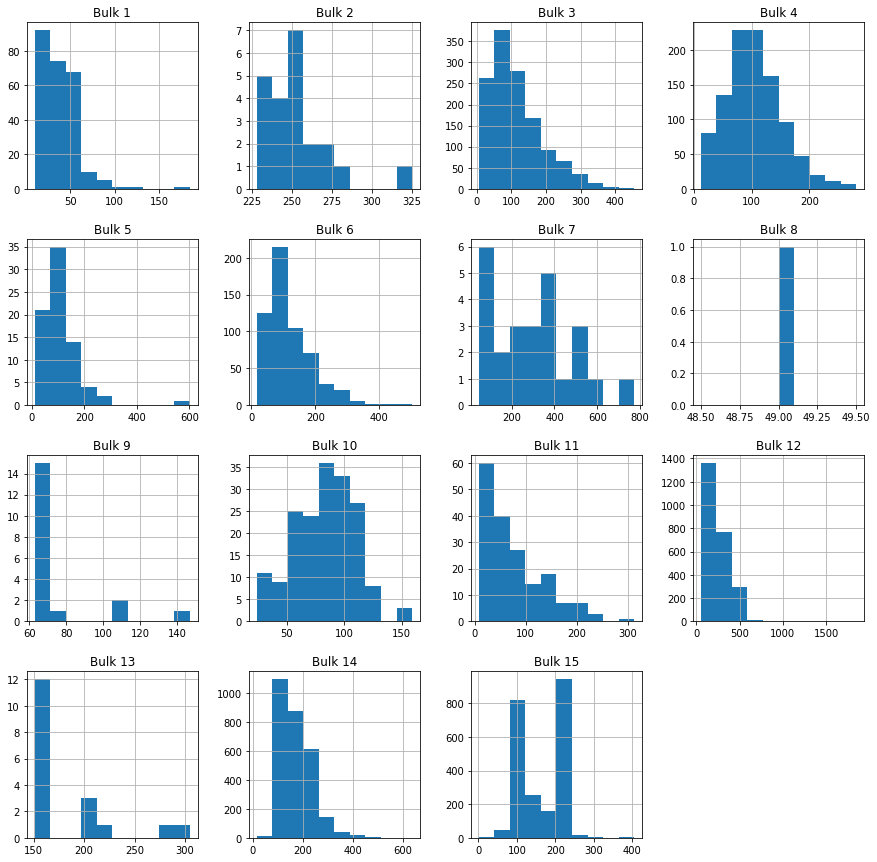

In [13]:
data_bulk.drop('key', axis=1).hist(figsize=(15, 15));

In [14]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [15]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Данные таблиц о подаче сыпучих материалов имеют одинаковую структуру и связаны между собой. Имеется большая доля пропусков, которые означают, что конкретный материал не использовался в производстве партии, следовательно эти пропуски можно заменить на нули. 

Данные о времени не пригодятся в обучении модели. 

### Продувка сплава газом

In [16]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [17]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [18]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


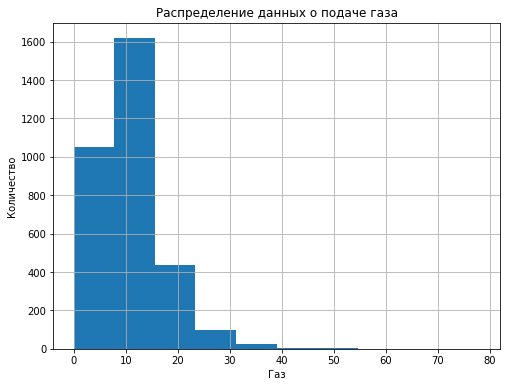

In [19]:
data_gas['Газ 1'].hist(figsize=(8, 6))
plt.title('Распределение данных о подаче газа')
plt.xlabel('Газ')
plt.ylabel('Количество');

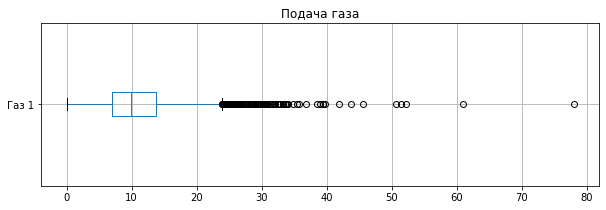

In [20]:
data_gas['Газ 1'].plot(kind='box', grid=True, vert=False, 
                       figsize=(10, 3), title='Подача газа');

В данных о подаче газа нет пропусков. На каждую партию была одна продувка газом. Имеющиеся выбросы удалять нецелесообразно, так как мы располагаем реальными данными.

### Температура

In [21]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [22]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [23]:
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


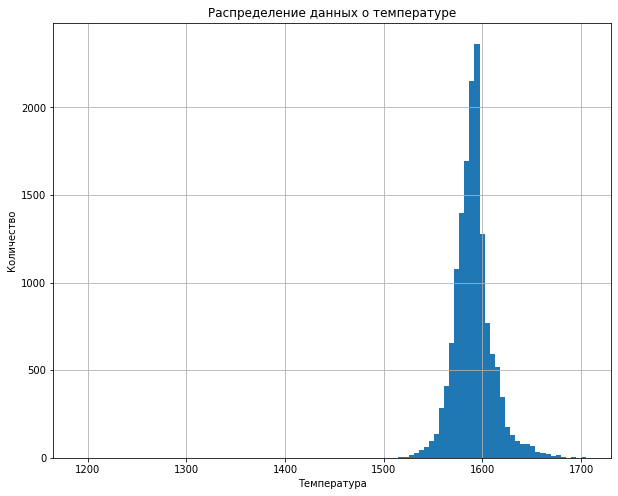

In [24]:
data_temp['Температура'].hist(bins=100, figsize=(10, 8))
plt.title('Распределение данных о температуре')
plt.xlabel('Температура')
plt.ylabel('Количество');

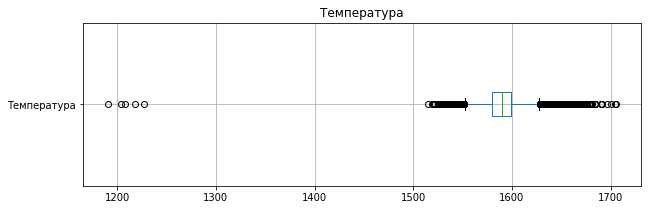

In [25]:
data_temp['Температура'].plot(kind='box', grid=True, vert=False, 
                              figsize=(10, 3), title='Температура');

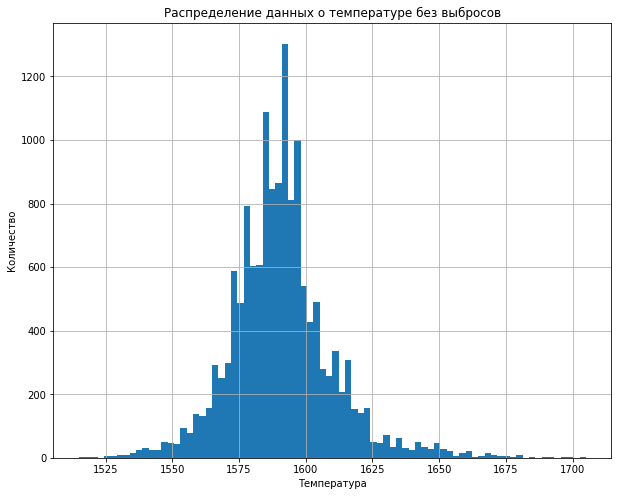

In [26]:
(data_temp[data_temp['Температура']>1500]['Температура']
 .hist(bins=80, figsize=(10, 8)))
plt.title('Распределение данных о температуре без выбросов')
plt.xlabel('Температура')
plt.ylabel('Количество');

In [27]:
data_temp.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

Согласно условию температура ниже 1500 не является нормальной. Данные выбросы придется удалить.

Для обучения модели в качестве признака можно использовать начальную температуру. Температура на последнем этапе обработки - целевой признак. Имеются пропуски в данных.

Данные о дате и времени нам не понадобятся.

### Проволочные материалы

In [28]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


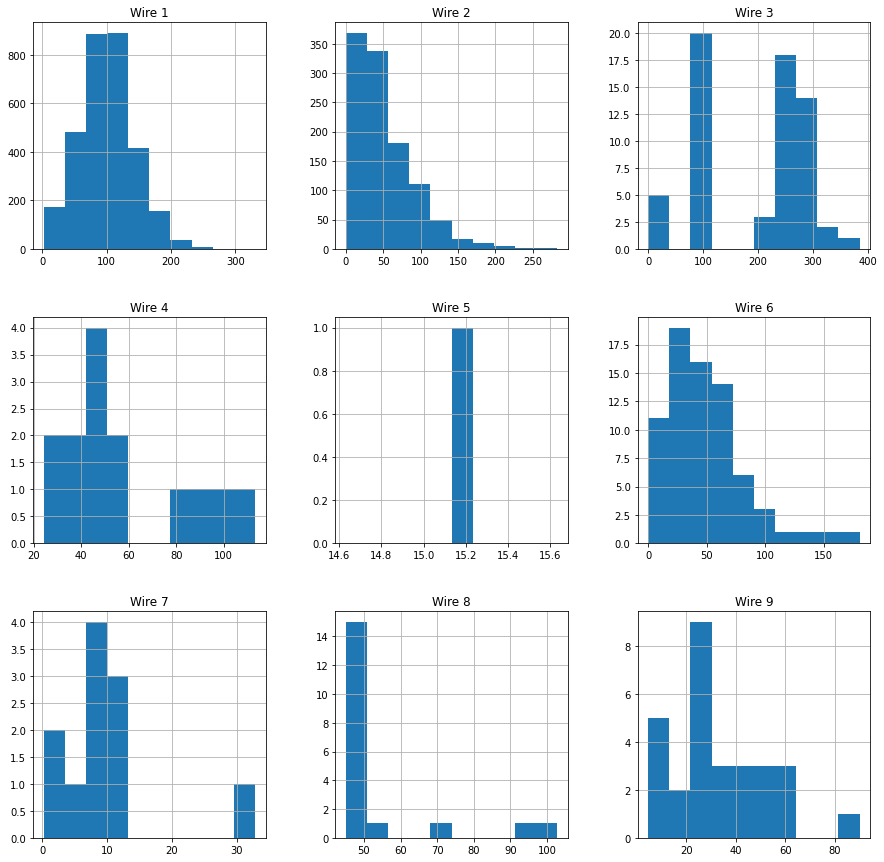

In [30]:
data_wire.drop('key', axis=1).hist(figsize=(15, 15));

In [31]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Данные двух таблиц о проволочных материалов имеют одинаковую структуру. Имеются пропуски, что как и в случае с добавлением сыпучих материалов, означает, что в производстве конкретной партии материалы не использовались. Пропуски заменяем на нули. 

Данные о дате и времени не понадобятся для обучения модели.

### Выводы

В нашем распоряжение данные из 7 файлов. Практически в каждом из них данные сгруппированы по ключу партии. Имеются пропуски в данных о сыпучих и проволочных материалов, в данных о температуре. А также аномальные значения мощности, температуры и о подаче газа.

**План работы**

1. Предобработка данных
    - Пропуски - заменяем на нули пропуски в данных о подаче сыпучих и проволочных материалов; в таблице о значении температуры оставляем первую и последнию, если будут пропуски, то удаляем. 
    - Дубликаты - в некоторых таблицах есть повторяющиеся ключи, эти дубликаты удаляем.
    - Аномалии - удаляем отрицательное значение реактивной мощности и отсекаем значение температуры ниже 1500.
    - Данные о дате и времени сами по себе не нужны, поэтому практически во всех таблицах мы их не берем.
3. Подготовка данных к обучению
    - Создание признаков - можно вычислить общее время нагрева из таблицы об электродах в качестве дополнительного признака, а также полную мощность.
    - Объединим оставшиеся данные в одну таблицу по ключу, который есть во всех таблицах.
    - Разделение данных на две выборки
    - Маштабирование/нормировка
5. Обучение моделей
    - Модель линейно регрессии или случайного леса.
    - Модель градиентного бустинга.
    - Подбор гипперпараметров.
    - Вычислим целевую метрику MAE для лучшей модели.
    - Проверим лучшую модель на тестовой выборке и на константе.
7. Составление отчета

## Подготовка данных

### Предобработка

In [33]:
# электроды

data_arc.columns = ['key', 'start_time', 'end_time', 
                    'active_power', 'reactive_power']
data_arc[['start_time', 'end_time']] = (
    data_arc[['start_time', 'end_time']].apply(pd.to_datetime))

# удалим аномалию
data_arc = data_arc[data_arc['reactive_power']>0]

display(data_arc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14875 non-null  int64         
 1   start_time      14875 non-null  datetime64[ns]
 2   end_time        14875 non-null  datetime64[ns]
 3   active_power    14875 non-null  float64       
 4   reactive_power  14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


None

In [34]:
# температура
data_temp.columns = ['key', 'time', 'temp']
data_temp['time'] = pd.to_datetime(data_temp['time'])

# удалим аномальные значения
#data_temp = data_temp[data_temp['temp'] > 1500]

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     18092 non-null  int64         
 1   time    18092 non-null  datetime64[ns]
 2   temp    14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [35]:
data_temp[data_temp['key']>=2500]

,key,time,temp
13926,2500,2019-08-10 14:04:39,1539.0
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [36]:
data_temp = data_temp[data_temp['key']<=2500]
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13931 entries, 0 to 13930
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     13931 non-null  int64         
 1   time    13931 non-null  datetime64[ns]
 2   temp    13927 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.3 KB


In [37]:
# сыпучие материалы
# заполним пропуски
data_bulk = data_bulk.fillna(0)
display(data_bulk.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

In [38]:
# проволочные материалы
# заполним пропуски
data_wire = data_wire.fillna(0)
display(data_wire.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

In [39]:
# газ
data_gas.columns = ['key', 'gas']
display(data_gas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

**Вывод:** Привели наименовани колонок во всех датафреймах к единому виду. Заполнили/удалили пропуски и аномалии.

### Создание признаков

В качестве дополнительных признаков найдем следующее:
* полную мощность
* общее время нагрева
* время между замерами температуры

In [40]:
# полная мощность и время нагрева
data_arc['total_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5
data_arc['heating_time'] = ((data_arc['end_time'] - data_arc['start_time'])
                            .apply(pd.Timedelta.total_seconds))

data_arc_grouped = data_arc.groupby('key').agg('sum')
data_arc_grouped = data_arc_grouped.drop(['active_power', 'reactive_power'], axis=1)

display(data_arc_grouped.head())
display(data_arc_grouped.info())

,total_power,heating_time
key,,
1,3.718736,1098.0
2,2.588349,811.0
3,5.019223,655.0
4,3.400038,741.0
5,2.816980,869.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_power   3214 non-null   float64
 1   heating_time  3214 non-null   float64
dtypes: float64(2)
memory usage: 75.3 KB


None

In [41]:
# первая и последняя температуры
data_temp_grouped = (data_temp.sort_values(by='time').groupby('key')
                     .agg({'temp':['first', 'last'], 'time':['first', 'last']}))
data_temp_grouped.columns = ['temp_first', 'temp_last', 'start_time', 'end_time']

display(data_temp_grouped.head())
display(data_temp_grouped.info())

,temp_first,temp_last,start_time,end_time
key,,,,
1,1571.0,1613.0,2019-05-03 11:02:04,2019-05-03 11:30:38
2,1581.0,1602.0,2019-05-03 11:34:04,2019-05-03 11:55:09
3,1596.0,1599.0,2019-05-03 12:06:44,2019-05-03 12:35:57
4,1601.0,1625.0,2019-05-03 12:39:27,2019-05-03 12:59:47
5,1576.0,1602.0,2019-05-03 13:11:03,2019-05-03 13:36:39


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2478 entries, 1 to 2500
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   temp_first  2478 non-null   float64       
 1   temp_last   2478 non-null   float64       
 2   start_time  2478 non-null   datetime64[ns]
 3   end_time    2478 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.8 KB


None

In [42]:
data_temp_grouped[data_temp_grouped['temp_first']<1500]

,temp_first,temp_last,start_time,end_time
key,,,,
867,1191.0,1599.0,2019-06-06 08:03:39,2019-06-06 08:48:23
1214,1208.0,1591.0,2019-06-18 08:01:03,2019-06-18 08:43:56
1619,1218.0,1590.0,2019-07-03 02:34:41,2019-07-03 02:43:59
2052,1227.0,1592.0,2019-07-25 08:49:15,2019-07-25 09:27:03


In [43]:
data_temp_grouped[data_temp_grouped['temp_last']<1500]

,temp_first,temp_last,start_time,end_time
key,,,,


In [45]:
data_temp_grouped = data_temp_grouped[data_temp_grouped['temp_first']>1500]
data_temp_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2474 entries, 1 to 2500
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   temp_first  2474 non-null   float64       
 1   temp_last   2474 non-null   float64       
 2   start_time  2474 non-null   datetime64[ns]
 3   end_time    2474 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.6 KB


In [46]:
# время между замерами
data_temp_grouped['temp_time'] = (
    (data_temp_grouped['end_time'] - data_temp_grouped['start_time'])
    .apply(pd.Timedelta.total_seconds))

data_temp_grouped = data_temp_grouped.drop(['start_time', 'end_time'], axis=1)

display(data_temp_grouped.head())
display(data_temp_grouped.info())

,temp_first,temp_last,temp_time
key,,,
1,1571.0,1613.0,1714.0
2,1581.0,1602.0,1265.0
3,1596.0,1599.0,1753.0
4,1601.0,1625.0,1220.0
5,1576.0,1602.0,1536.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2474 entries, 1 to 2500
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp_first  2474 non-null   float64
 1   temp_last   2474 non-null   float64
 2   temp_time   2474 non-null   float64
dtypes: float64(3)
memory usage: 77.3 KB


None

In [47]:
# Объединим полученные датасеты в один.
data = (data_arc_grouped.merge(data_bulk, on='key', how='inner')
                   .merge(data_gas, on='key', how='inner')
                   .merge(data_wire, on='key', how='inner')
                   .merge(data_temp_grouped, on='key', how='inner'))

display(data.head())
display(data.info())

,key,total_power,heating_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,temp_first,temp_last,temp_time
0,1,3.718736,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1613.0,1714.0
1,2,2.588349,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1581.0,1602.0,1265.0
2,3,5.019223,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1599.0,1753.0
3,4,3.400038,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1601.0,1625.0,1220.0
4,5,2.816980,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1576.0,1602.0,1536.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2326 entries, 0 to 2325
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2326 non-null   int64  
 1   total_power   2326 non-null   float64
 2   heating_time  2326 non-null   float64
 3   Bulk 1        2326 non-null   float64
 4   Bulk 2        2326 non-null   float64
 5   Bulk 3        2326 non-null   float64
 6   Bulk 4        2326 non-null   float64
 7   Bulk 5        2326 non-null   float64
 8   Bulk 6        2326 non-null   float64
 9   Bulk 7        2326 non-null   float64
 10  Bulk 8        2326 non-null   float64
 11  Bulk 9        2326 non-null   float64
 12  Bulk 10       2326 non-null   float64
 13  Bulk 11       2326 non-null   float64
 14  Bulk 12       2326 non-null   float64
 15  Bulk 13       2326 non-null   float64
 16  Bulk 14       2326 non-null   float64
 17  Bulk 15       2326 non-null   float64
 18  gas           2326 non-null 

None

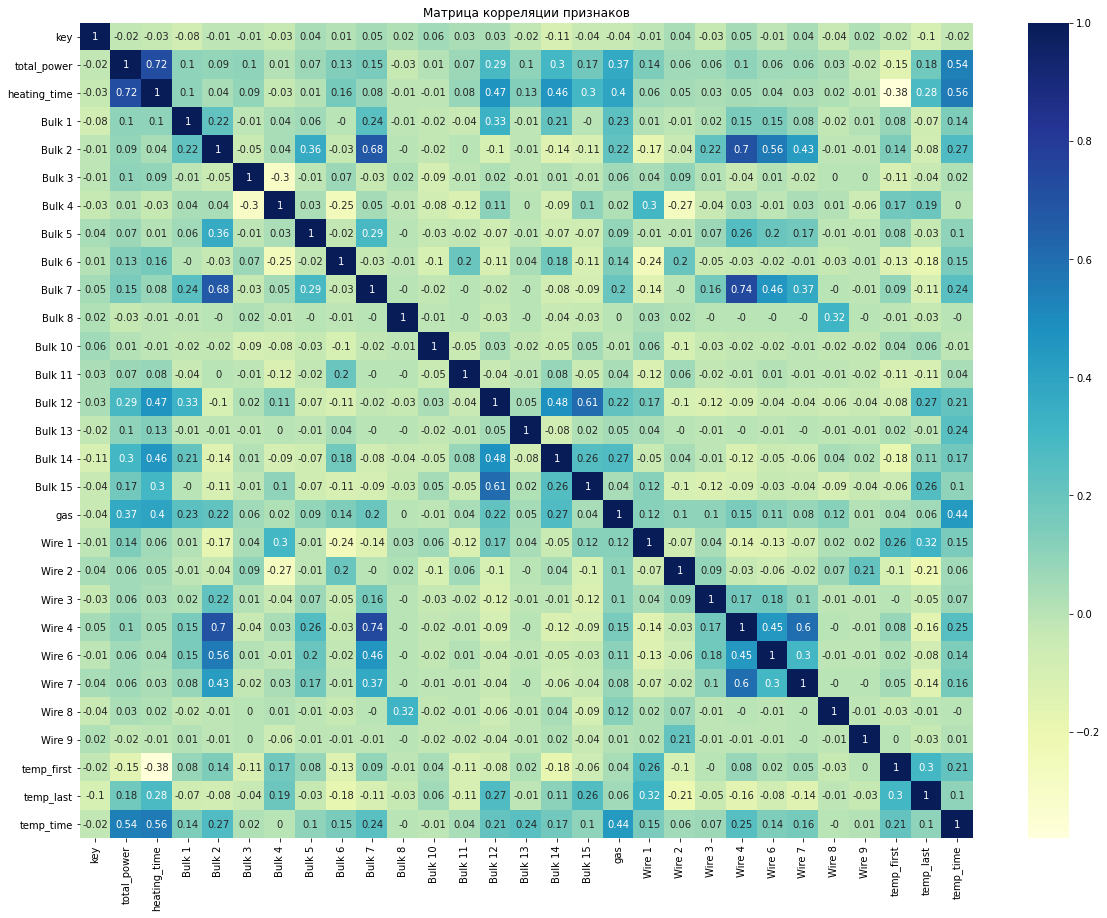

In [54]:
# корреляция признаков
plt.figure(figsize=(20, 15))
sns.heatmap(round(data.corr(), 2), cmap="YlGnBu", annot=True)
plt.title('Матрица корреляции признаков')
plt.show();

In [53]:
data = data.drop(['Bulk 9'], axis=1)

In [50]:
data['Wire 5'].value_counts()

0.0    2326
Name: Wire 5, dtype: int64

In [52]:
data = data.drop(['Wire 5'], axis=1)

**Вывод:** Создали новые признаки и объединили все в один датафрейм. Признаки проверили на мультиколлинеарность. Есть сильная зависимость между признакми Bulk 9 и Wire 8, поэтому один из них удалили. 

## Обучение моделей

In [55]:
random_state = 12923

# выделим целевой признак
features = data.drop(['key', 'temp_last'], axis=1)
target = data['temp_last']

# разделим на две выборки в соотношении 75:25
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=0.25, random_state=random_state)

display(train_features.shape, train_target.shape[0])
display(test_features.shape, test_target.shape[0])

(1744, 27)

1744

(582, 27)

582

### LinearRegression

In [56]:
%%time
lr_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LinearRegression())
    ])

lr_params = {}

lr_grid_search = GridSearchCV(lr_pipe, lr_params, n_jobs=-1,
                              cv=5, scoring='neg_mean_absolute_error')
lr_grid_search.fit(train_features, train_target)
display(lr_grid_search.best_params_)
lr_score = abs(lr_grid_search.best_score_)
display(lr_score)

{}

6.011728055916144

CPU times: user 296 ms, sys: 433 ms, total: 729 ms
Wall time: 684 ms


### RandomForest

In [57]:
%%time
rf_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(random_state=random_state))
    ])

rf_params = {'rf__n_estimators': [150, 200, 250],
             'rf__max_depth': [6, 12, 20],
             'rf__min_samples_split': [2, 5, 10]
            }

rf_grid_search = GridSearchCV(rf_pipe, rf_params, n_jobs=-1,
                              cv=5, scoring='neg_mean_absolute_error')
rf_grid_search.fit(train_features, train_target)
display(rf_grid_search.best_params_)
rf_score = abs(rf_grid_search.best_score_)
display(rf_score)

{'rf__max_depth': 12, 'rf__min_samples_split': 10, 'rf__n_estimators': 250}

6.07581182018391

CPU times: user 2min 53s, sys: 491 ms, total: 2min 54s
Wall time: 2min 54s


### CatBoost

In [58]:
%%time
cb_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('cb', CatBoostRegressor(random_state=random_state))
    ])

cb_params = {'cb__n_estimators': [200, 250],
             'cb__learning_rate': [0.01, 0.05, 0.1],
             'cb__max_depth': [3, 4, 5]
            }

cb_grid_search = GridSearchCV(cb_pipe, cb_params, n_jobs=-1,
                              cv=5, scoring='neg_mean_absolute_error')
cb_grid_search.fit(train_features, train_target)
display(cb_grid_search.best_params_)
cb_score = abs(cb_grid_search.best_score_)
display(cb_score)

0:	learn: 11.4678618	total: 47.2ms	remaining: 9.39s
1:	learn: 11.4478713	total: 48.1ms	remaining: 4.76s
2:	learn: 11.4259205	total: 49ms	remaining: 3.22s
3:	learn: 11.4012350	total: 50ms	remaining: 2.45s
4:	learn: 11.3851861	total: 50.9ms	remaining: 1.99s
5:	learn: 11.3600583	total: 51.9ms	remaining: 1.68s
6:	learn: 11.3401638	total: 52.8ms	remaining: 1.46s
7:	learn: 11.3205941	total: 53.7ms	remaining: 1.29s
8:	learn: 11.3038009	total: 54.6ms	remaining: 1.16s
9:	learn: 11.2803034	total: 55.5ms	remaining: 1.05s
10:	learn: 11.2596998	total: 56.3ms	remaining: 968ms
11:	learn: 11.2454803	total: 57.1ms	remaining: 895ms
12:	learn: 11.2221740	total: 58.1ms	remaining: 835ms
13:	learn: 11.2044077	total: 59.1ms	remaining: 785ms
14:	learn: 11.1895427	total: 60.1ms	remaining: 741ms
15:	learn: 11.1677992	total: 60.9ms	remaining: 701ms
16:	learn: 11.1476892	total: 61.8ms	remaining: 666ms
17:	learn: 11.1292159	total: 62.7ms	remaining: 634ms
18:	learn: 11.1114757	total: 63.5ms	remaining: 605ms
19:	lea

{'cb__learning_rate': 0.1, 'cb__max_depth': 5, 'cb__n_estimators': 200}

5.860782003997956

CPU times: user 32.2 s, sys: 2.32 s, total: 34.5 s
Wall time: 1min 43s


### LGBMRegressor

In [59]:
%%time
lgb_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('lgb', LGBMRegressor(random_state=random_state))
    ])

lgb_params = {'lgb__n_estimators': [50, 100, 200],
              'lgb__learning_rate': [0.01, 0.05, 0.1],
              'lgb__num_leaves': [20, 30, 40]
             }

lgb_grid_search = GridSearchCV(lgb_pipe, lgb_params, n_jobs=-1,
                              cv=5, scoring='neg_mean_absolute_error')
lgb_grid_search.fit(train_features, train_target)
display(lgb_grid_search.best_params_)
lgb_score = abs(lgb_grid_search.best_score_)
display(abs(lgb_score))

{'lgb__learning_rate': 0.05, 'lgb__n_estimators': 100, 'lgb__num_leaves': 20}

6.057971178185372

CPU times: user 3min 10s, sys: 1.5 s, total: 3min 11s
Wall time: 3min 13s


In [60]:
# результаты
results = pd.DataFrame({'Model':['LinearRegression', 'RandomForest', 'CatBoost', 'LGBM'], 
                        'Score':[lr_score, rf_score, cb_score, lgb_score]})

results

,Model,Score
0,LinearRegression,6.011728
1,RandomForest,6.075812
2,CatBoost,5.860782
3,LGBM,6.057971


### Проверка лучшей модели

In [61]:
%%time
test_pred = cb_grid_search.best_estimator_.predict(test_features)
test_score = mean_absolute_error(test_target, test_pred)
print('MAE тестовой выборки', test_score)

MAE тестовой выборки 5.867101566350443
CPU times: user 3.7 ms, sys: 0 ns, total: 3.7 ms
Wall time: 3.37 ms


**Вывод:** Лучшей моделью оказалась модель CatBoost.

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


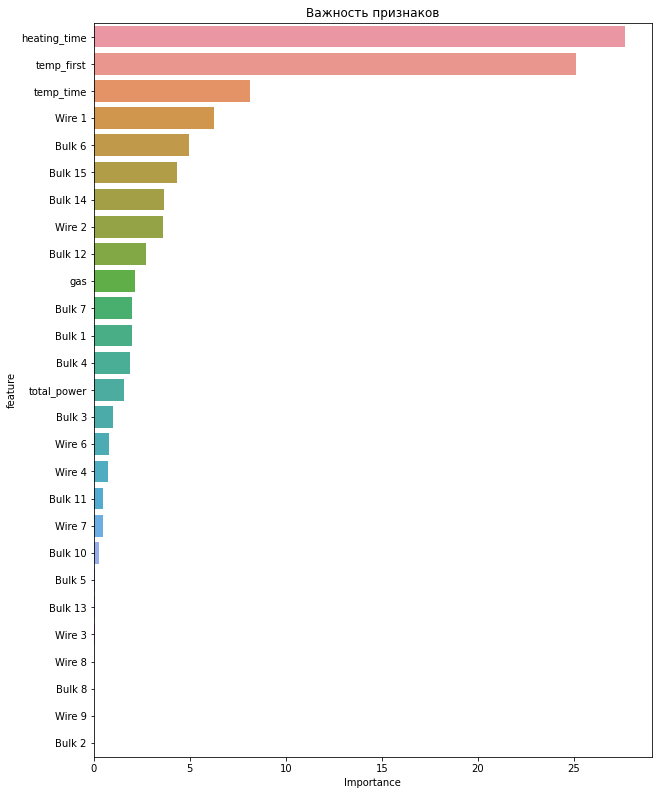

In [88]:
model = CatBoostRegressor(random_state=random_state, 
                          learning_rate=0.1,
                          max_depth=5,
                          n_estimators=200, verbose=0)
model.fit(train_features, train_target)

feature_importances = pd.DataFrame({'feature': train_features.columns, 'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)
       
plt.figure(figsize = (10, len(feature_importances) * 0.5))
sns.barplot(feature_importances['importance'], feature_importances['feature'])
plt.xlabel('Importance')
plt.title('Важность признаков')
plt.show()

## Отчет по решению

Для исследования и обучения модели были предоставлены 7 файлов с данными об электродах, сыпучих и проволочных материалов, о продувке газом и температуры. Предстояла задача обучить модель предсказывать температуру стали, чтобы таким образом снизить протребление элетроэнергии на этапе обработки.

Было сделано следующее:
* Проведен исследовательский анализ данных всех файлов. Найдены различные артефакты: пропуски и аномалии. На основании этой информации был составлен план решения задачи.

* Сделали предобработку данных. В данных об электродах и замерах температуры сгруппировали записи по номерам партии, так как в этих файлах было по нескольку строк на партию, что соотвествовало разным итерациям обработки. Также в этих файлах были замечаны аномальные значения реактивной мощности (единственное отрицательное значение) и температуры (по условию она не может быть ниже 1500), они были устранены. В данных об объеме сыпучих и проволочных материалов была большая доля пропусков, которые заменили на нули. Те же данные, но о дате и времени решено было не использовать.

* Для обучения модели создали новые признаки: полную мощность, время нагрева и время между замерами температуры. Полную мощность посчитали на основании данных об активной и реактивной мощности по формуле. Из данных о температуре оставили только первую и последнюю записи за партию. Последняя температуры - целевой признак. Пришлось удалить ключи от 2500, так как они оказались неинформативны.

* Создали новую таблицу с признакми. В нее вошли: полная мощность, время нагрева, первая и последняя температуры, время между замерами, газ, все признаки сыпучих материалов, кроме 9, и все признаки проволочных материалов, кроме 5. Признаки были проверены на мультиколлинеарность.

* Для сравнения были обучены модель Линейной регрессии, Случайного леса, CatBoost и LGBM. Использовали кросс-валидацию, применив алгорим автоматического поиска параметров. Посчитали целевую метрику MAE. Затем лучшую модель проверили на тестовой выборке.

Лучшая модель: CatBoost 
- Параметры модели: learning_rate=0.1, max_depth=5 и n_estimators=200
- MAE на обучающей выборке 5.86, на тестовой - 5.87
- Наиболее важный признак при обучении модели - время нагрева и первая температура.